To obtain a clean sample we need to choose a requirement on the signal score. This is achieved by looking at signal and background yields in data as a function of the BDT score. The yields are determined from a fit to the mass distribution, where a polynominal is used to model background, and a Gaussian for signal. An example fit is shown below.

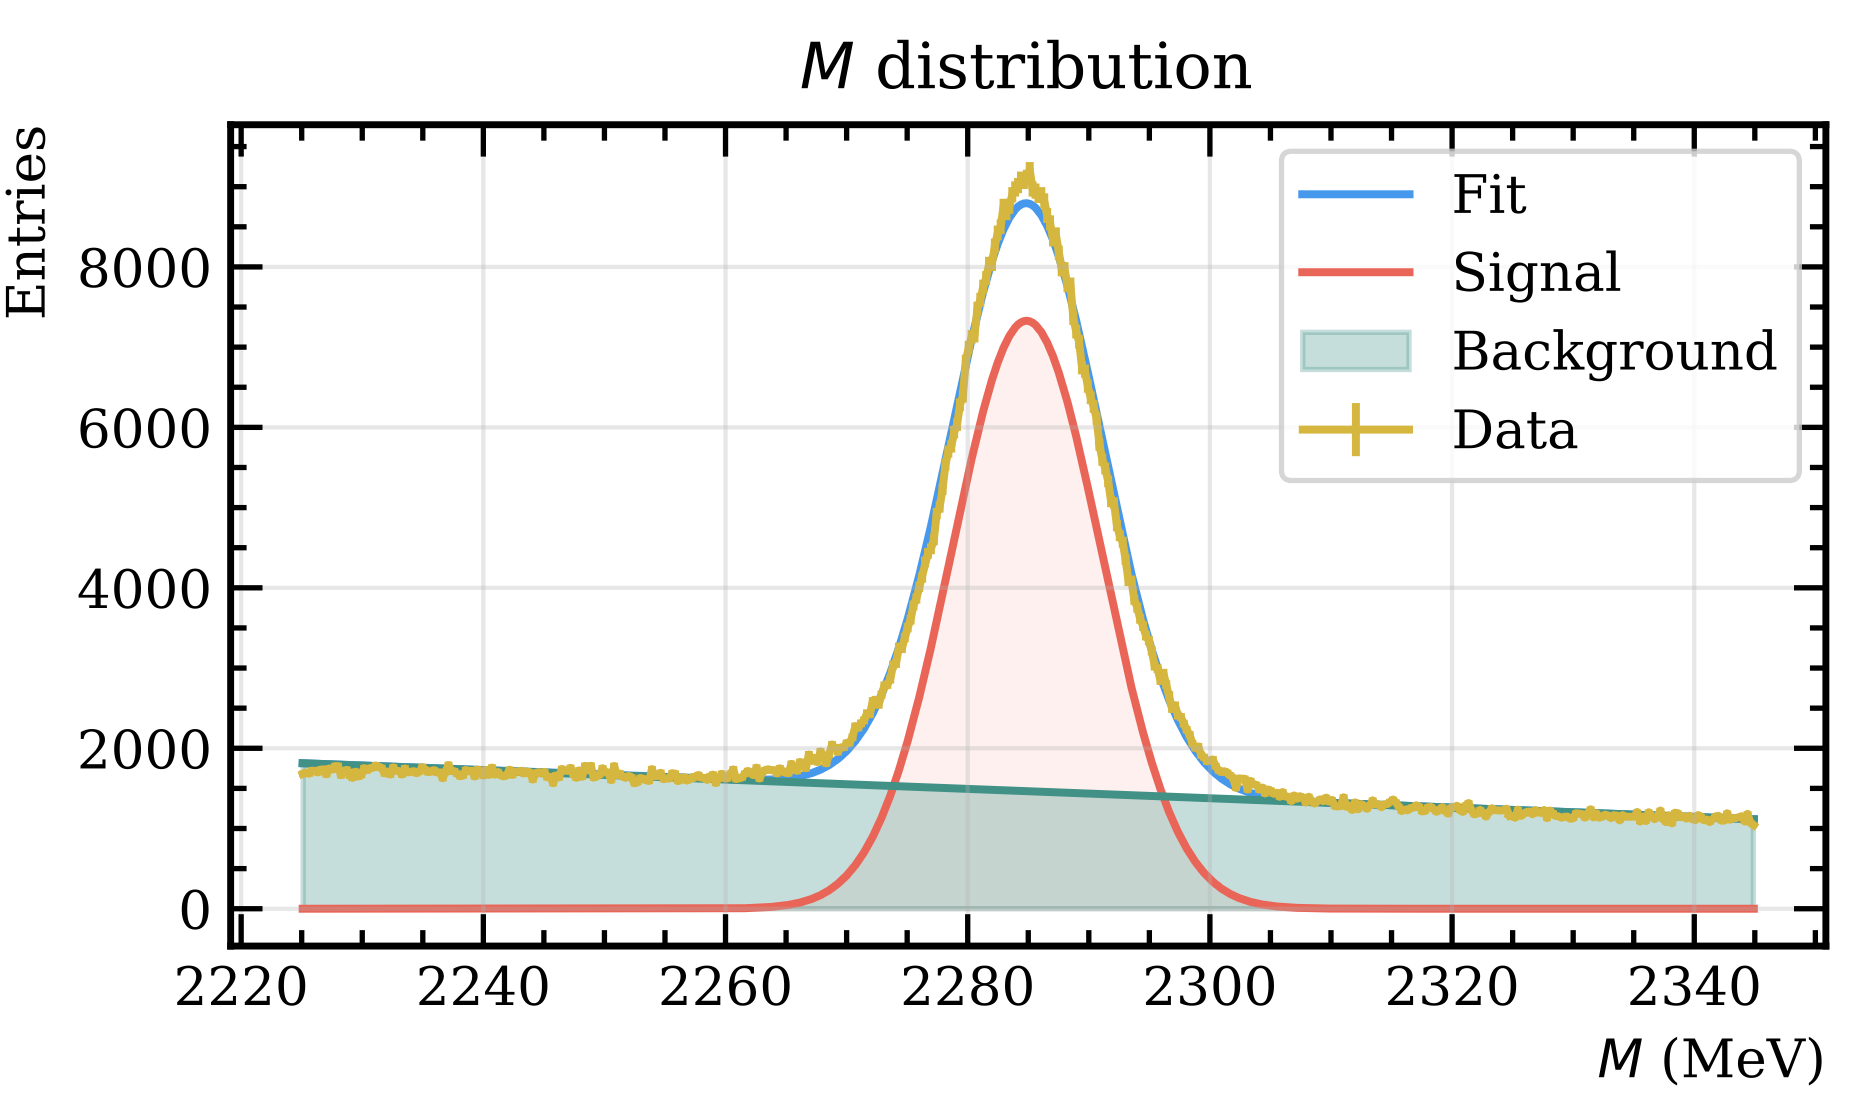

In [1]:
from wand.image import Image as WImage
img = WImage(filename='/data/lhcb/users/mackay/LcTraining/reduced/fits/example_fit.png')
img

### Load in the results of the scans

In [23]:
import numpy as np
import json

def purity(s, b):
    return s / (s+b)

def significance(s, b):
    return s / np.sqrt(s+b)

def eff(y, y_no_cut):
    return y / y_no_cut

general_results_path = "/data/lhcb/users/mackay/LcTraining/{}/fits/"
scan_values = np.linspace(0., 0.85, 18)
all_results = {}
training_to_check = ["reduced", "reduced_after_comp"]
for train in training_to_check:
    
    results = {cut : [] for cut in scan_values}
    signal_yield_with_no_cut = 0
    bkg_yield_with_no_cut = 0
    for cut in scan_values:
        
        with open("{}lc2pkpi_{:.2f}.json".format(general_results_path.format(train), cut)) as f:
            fit_results = json.load(f)
            
        total_yield = fit_results[0][0]
        bkg_fraction = fit_results[0][1]
        
        signal_yield = total_yield * (1-bkg_fraction)
        bkg_yield = total_yield * bkg_fraction
        if cut == 0:
            signal_yield_with_no_cut = signal_yield
            bkg_yield_with_no_cut = bkg_yield

        results[cut].append(signal_yield)
        results[cut].append(signal_yield * (147/20))
        results[cut].append(bkg_yield)
        results[cut].append( purity(signal_yield, bkg_yield) )
        results[cut].append( significance(signal_yield, bkg_yield) )
        results[cut].append( eff(signal_yield, signal_yield_with_no_cut) )  
        results[cut].append( 1 - eff(bkg_yield, bkg_yield_with_no_cut) )  
        
    all_results[train] = results

### Load in v3 scan
v2 of the BDT contained a variable (pion momentum) which biased the efficiencies we were interested in calculating. The results are loaded in separately from v1 and v2 becuase a finer scan was performed.

In [27]:
scan_values = np.linspace(0., 0.85, 35)

for train in ["apply_no_pid"]:
    
    results = {cut : [] for cut in scan_values}
    signal_yield_with_no_cut = 0
    bkg_yield_with_no_cut = 0
    for cut in scan_values:
        
        with open("{}lc2pkpi_{:.3f}.json".format(general_results_path.format(train), cut)) as f:
            fit_results = json.load(f)
            
        total_yield = fit_results[0][0]
        bkg_fraction = fit_results[0][1]
        
        signal_yield = total_yield * (1-bkg_fraction)
        bkg_yield = total_yield * bkg_fraction
        if cut == 0:
            signal_yield_with_no_cut = signal_yield
            bkg_yield_with_no_cut = bkg_yield

        results[cut].append(signal_yield)
        results[cut].append(signal_yield * (147/20))
        results[cut].append(bkg_yield)
        results[cut].append( purity(signal_yield, bkg_yield) )
        results[cut].append( significance(signal_yield, bkg_yield) )
        results[cut].append( eff(signal_yield, signal_yield_with_no_cut) )  
        results[cut].append( 1 - eff(bkg_yield, bkg_yield_with_no_cut) )  
        
    all_results[train] = results

### Compare varios metrics

The "v2" BDT  uses training variables which show better agreement between data and MC (see the ```CheckMCDistributions.ipynb``` notebook).

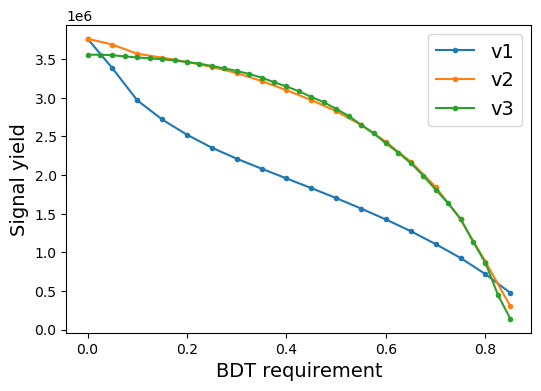

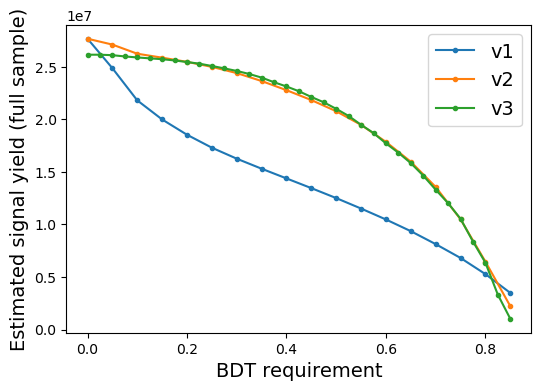

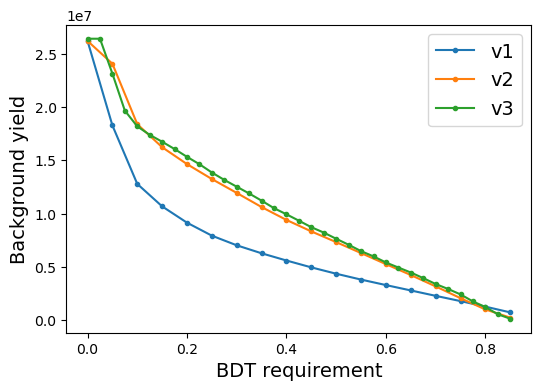

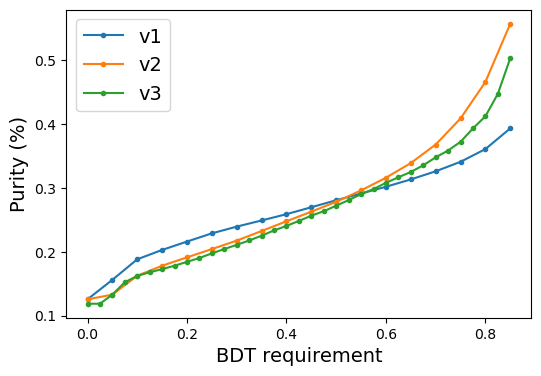

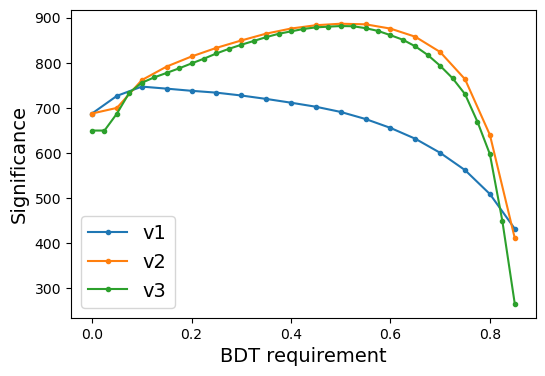

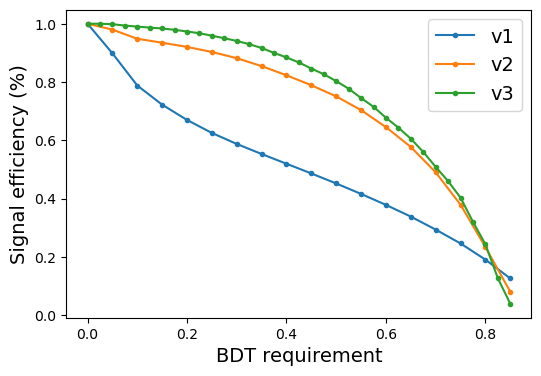

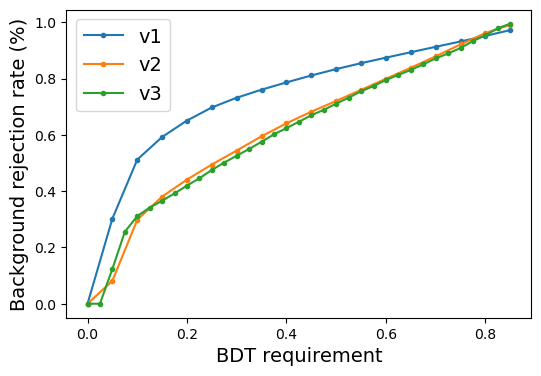

In [28]:
import matplotlib.pyplot as plt

plot_labels = {
    "reduced": "v1",
    "reduced_after_comp": "v2",
    "apply_no_pid": "v3",
}

for i, metric in enumerate(["Signal yield", "Estimated signal yield (full sample)", "Background yield", "Purity (%)", "Significance", "Signal efficiency (%)", "Background rejection rate (%)"]):
    fig, ax = plt.subplots(figsize=(6,4))
    for train in training_to_check + ["apply_no_pid"]:
        sv = list(all_results[train].keys())
        ax.plot(
            sv,
            [all_results[train][cut][i] for cut in sv],
            marker='.',
            label=plot_labels[train]
        )
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel("BDT requirement", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)